## Data Understanding - Part 1
### Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

batting = pd.read_csv('./data/Batting.csv')
fielding = pd.read_csv('./data/Fielding.csv')
salaries = pd.read_csv('./data/Salaries.csv')
inflation = pd.read_csv('./data/Inflation.csv')
minSalary = pd.read_csv('./data/MinimumSalaries.csv')
pitching = pd.read_csv('./data/Pitching.csv')
people = pd.read_csv('./data/People.csv')

#Rename Column Names to standardize with Lahman database columns and remove spaces
inflation = inflation.rename(index=str, columns={'Year': 'yearID'})
minSalary = minSalary.rename(index=str, columns={'Year': 'yearID', 'MinSalaries ': 'MinSalaries'})

#print('Batting', batting.info())
#print('Fielding', fielding.info())
#print('Salaries', salaries.info())
#print('Inflation', inflation.info())
#print('Minimum Salary', minSalary.info())
#print('Pitching', pitching.info())

In [2]:
## Go back and convert to table ##
#teamNullCols = pd.DataFrame({'n Missing' : teamNullCols, '% Missing' : ((teamNullCols / teams2.shape[0])*100).round(2)#.astype(str) + "%"})

print("Shape of DataFrames:", "Batting:", batting.shape, "Fielding:", fielding.shape, "Salaries:", salaries.shape, "Inflation:", inflation.shape, "Minimum Salary:", minSalary.shape, "Pitching:", pitching.shape)

Shape of DataFrames: Batting: (104324, 24) Fielding: (138838, 18) Salaries: (26428, 5) Inflation: (33, 4) Minimum Salary: (51, 2) Pitching: (45806, 30)


### Subsetting by Year

As can be seen above, a one to one match does not exist between the four source tables. The process of creating dataframes which can be merged into a single dataframe will begin with row level filtering. Only records from the 1985 season and greater will be used for analysis in this assignment. 1985 was chosen for two reasons.  

First, salary data only goes back to 1985.  

Second, the evolution of the game and it players have changed quite a bit since beginning of the professional game of baseball. Selecting only records from the 1985 season and forward provides a 32-year data set while eliminating data that would likely lead to erroneous results.  

In [3]:
#awards = awards[awards.yearID > 1984]
batting = batting[batting.yearID > 1984]
fielding = fielding[fielding.yearID > 1984]
salaries = salaries[salaries.yearID > 1984]
minSalary = minSalary[minSalary.yearID > 1984]
pitching = pitching[pitching.yearID > 1984]

print("Shape of DataFrames:", "Batting:", batting.shape, "Fielding:", fielding.shape, "Salaries:", salaries.shape, "Inflation:", inflation.shape, "Minimum Salary:", minSalary.shape, "Pitching:", pitching.shape)

Shape of DataFrames: Batting: (42071, 24) Fielding: (54560, 18) Salaries: (26428, 5) Inflation: (33, 4) Minimum Salary: (33, 2) Pitching: (20822, 30)


### Batting

The Batting table will be the driver for the overall consolidated data frame.  In other words, fielding, salaries and awards will be merged into the Batting data frame.  First, categorical variables such as Team and League ID which offer limited predictive or structural value will be dropped from the data frame.  The G_old column is missing values in every row and will be dropped as well.

In [4]:
batting = batting.drop(['teamID', 'lgID', 'G_old', 'G_batting', 'stint'], axis=1)
#Drop rows with no basic statistics are recorded in a year
#batting = batting[(batting[['AB', 'BB']] != 0).all(axis=1)]
batting = batting[(batting[['AB']] != 0).all(axis=1)]
print(batting.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30823 entries, 1 to 104305
Data columns (total 19 columns):
playerID    30823 non-null object
yearID      30823 non-null int64
G           30823 non-null int64
AB          30823 non-null int64
R           30823 non-null int64
H           30823 non-null int64
2B          30823 non-null int64
3B          30823 non-null int64
HR          30823 non-null int64
RBI         30823 non-null float64
SB          30823 non-null float64
CS          30823 non-null float64
BB          30823 non-null int64
SO          30823 non-null float64
IBB         30823 non-null float64
HBP         30823 non-null float64
SH          30823 non-null float64
SF          30823 non-null float64
GIDP        30823 non-null float64
dtypes: float64(9), int64(9), object(1)
memory usage: 4.7+ MB
None


There are approximately 1300 instances remaining where a player has more than one record per year in the batting data frame.  This is to be expected as player trades and multiple stints in the major league do occur in a single season.  These instances will be consolidated into a single row.

In [5]:
#Identify Instances where a player has more than one batting record per year.
df = batting.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]
print(df)

#Consolidate and Aggreagate
print(batting.groupby(['yearID', 'playerID']).sum().reset_index())
battingFinal = batting.groupby(['yearID', 'playerID']).sum().reset_index()

#print(battingFinal)
print(battingFinal.info())
print(battingFinal.describe())

        playerID  yearID  G  AB  R  H  2B  3B  HR  RBI  SB  CS  BB  SO  IBB  \
21     abbotku01    1998  2   2  2  2   2   2   2    2   2   2   2   2    2   
35     abernbr01    2003  2   2  2  2   2   2   2    2   2   2   2   2    2   
41     abnersh01    1991  2   2  2  2   2   2   2    2   2   2   2   2    2   
54     abreubo01    2006  2   2  2  2   2   2   2    2   2   2   2   2    2   
60     abreubo01    2012  2   2  2  2   2   2   2    2   2   2   2   2    2   
95     ackledu01    2015  2   2  2  2   2   2   2    2   2   2   2   2    2   
114    adamsma01    2017  2   2  2  2   2   2   2    2   2   2   2   2    2   
151    affelje01    2006  2   2  2  2   2   2   2    2   2   2   2   2    2   
162    agbaybe01    2002  2   2  2  2   2   2   2    2   2   2   2   2    2   
172    aguaylu01    1988  2   2  2  2   2   2   2    2   2   2   2   2    2   
217    aldremi01    1991  2   2  2  2   2   2   2    2   2   2   2   2    2   
220    aldremi01    1995  2   2  2  2   2   2   2   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28904 entries, 0 to 28903
Data columns (total 19 columns):
yearID      28904 non-null int64
playerID    28904 non-null object
G           28904 non-null int64
AB          28904 non-null int64
R           28904 non-null int64
H           28904 non-null int64
2B          28904 non-null int64
3B          28904 non-null int64
HR          28904 non-null int64
RBI         28904 non-null float64
SB          28904 non-null float64
CS          28904 non-null float64
BB          28904 non-null int64
SO          28904 non-null float64
IBB         28904 non-null float64
HBP         28904 non-null float64
SH          28904 non-null float64
SF          28904 non-null float64
GIDP        28904 non-null float64
dtypes: float64(9), int64(9), object(1)
memory usage: 4.2+ MB
None
             yearID             G            AB             R             H  \
count  28904.000000  28904.000000  28904.000000  28904.000000  28904.000000   
mean    2001.899668 

In [6]:
print("Index:", battingFinal.index)
print("Columns:", battingFinal.columns)

Index: RangeIndex(start=0, stop=28904, step=1)
Columns: Index(['yearID', 'playerID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')


### Fielding
The Fielding table contains most of the common defensive statistics in baseball.  The grain of this table is by player, year, stint and position.  It is common for players to play more than one position over the course of a season (year).  However, most players have a primary position.  There is also the concept of a utility player.  This a player who has no primary position and plays a significant number of games in many positions.  The end objective is to produce a final fielding file with data summarized at the player and year grain.  As this lab is focused on everyday position players, pitchers will be dropped from the fielding data frame.  

In [7]:
#fielding = fielding[fielding.POS != 'P']
print(fielding.info())
print(fielding.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54560 entries, 0 to 138837
Data columns (total 18 columns):
playerID    54560 non-null object
yearID      54560 non-null int64
stint       54560 non-null int64
teamID      54560 non-null object
lgID        54560 non-null object
POS         54560 non-null object
G           54560 non-null int64
GS          54545 non-null float64
InnOuts     54545 non-null float64
PO          54560 non-null int64
A           54560 non-null int64
E           54560 non-null float64
DP          54560 non-null int64
PB          3651 non-null float64
WP          0 non-null float64
SB          3651 non-null float64
CS          3651 non-null float64
ZR          0 non-null float64
dtypes: float64(8), int64(6), object(4)
memory usage: 7.9+ MB
None
             yearID         stint             G            GS       InnOuts  \
count  54560.000000  54560.000000  54560.000000  54545.000000  54545.000000   
mean    2002.048259      1.080334     35.466697     25.017087 

From the above describe statement, it's easy to see WP (wild pitch) and ZR (zone rating) are missing values in the entire column.  The two columns will be dropped from the fielding data frame.  To maintain consistency with the batting data frame, team and league will be dropped as well.  

In [8]:
fielding = fielding.drop(['teamID', 'lgID', 'WP', 'ZR'], axis=1)

There is high rate of missing values in the "PB", "SB" and "CS" columns.  This does make sense as these are statistics specific to catchers. Example: 'CS' - times player caught opponent stealing.  

The data was spot checked to verify these are accurate missing values.  These missing values will be replaced with zeroes.

In [9]:
fielding.fillna(value={'PB': 0, 'SB': 0, 'ZR': 0, 'CS': 0}, inplace = True)
#print(fielding.info())
print(fielding.describe())

             yearID         stint             G            GS       InnOuts  \
count  54560.000000  54560.000000  54560.000000  54545.000000  54545.000000   
mean    2002.048259      1.080334     35.466697     25.017087    670.333633   
std        9.417926      0.285750     40.092292     39.596628   1035.107817   
min     1985.000000      1.000000      1.000000      0.000000      0.000000   
25%     1994.000000      1.000000      6.000000      0.000000     55.000000   
50%     2002.000000      1.000000     20.000000      6.000000    202.000000   
75%     2010.000000      1.000000     50.000000     31.000000    667.000000   
max     2017.000000      4.000000    163.000000    162.000000   4388.000000   

                 PO             A             E            DP            PB  \
count  54560.000000  54560.000000  54560.000000  54560.000000  54560.000000   
mean      74.490836     28.644446      1.887353      6.913783      0.205718   
std      175.176243     71.381596      3.563496    

Next, a cursory check to verify players playing multiple positions per year exist in the fielding data frame.  

In [10]:
#Identify Players who played multiple positions per year.
df = fielding.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.stint > 1]
#print(df)

One of the more important steps of the data cleansing, aggregation and merging process is to idenfity a primary position for each player.

In [11]:
#Identify Primary Postion per Player per Year Based on Max Games at a position.
df = fielding.groupby(['playerID', 'yearID', 'POS']).sum().reset_index()
df = df.groupby(['playerID', 'yearID', 'POS'])['G'].max().reset_index()
#df = df.groupby(['playerID', 'yearID', 'POS']).max()['G']
df = df.sort_values(by=['playerID', 'yearID', 'G'], ascending=[True, True, False])
#print(df)
#print(df.describe())

primePOS = pd.DataFrame()
svPlayerID = ''
svYearID = 0

for index, row in df.iterrows():
    #print (row["playerID"], row["yearID"], row['POS'], row['G'])
    if (svPlayerID != row['playerID'] or svYearID != row['yearID']):
        primePOS = primePOS.append({'playerID': row['playerID'], 'yearID': row['yearID'], 'Primary': row['POS']}, ignore_index=True)
        #print(svPlayerID, row["playerID"], svYearID, row["yearID"], row['POS'], row['G'])
        svPlayerID = row['playerID']
        svYearID = row['yearID']
    else:
        continue
  

In [12]:
print(primePOS.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38453 entries, 0 to 38452
Data columns (total 3 columns):
Primary     38453 non-null object
playerID    38453 non-null object
yearID      38453 non-null float64
dtypes: float64(1), object(2)
memory usage: 901.3+ KB
None


In [13]:
#Condense Fielding Dataframe into one row per player per year.
fielding = fielding.groupby(['playerID', 'yearID']).sum().reset_index()

#Merge Primary Position into condensed Fielding data frame
fieldingFinal = pd.merge(fielding, primePOS, on=['playerID', 'yearID'], how='left')

#print(fieldingFinal)
print(fieldingFinal.describe())

              stint             G            GS       InnOuts            PO  \
count  38453.000000  38453.000000  38453.000000  38453.000000  38453.000000   
mean       1.532858     50.322810     35.486360    950.858139    105.693184   
std        1.209722     45.210944     46.258138   1210.394556    207.296502   
min        1.000000      1.000000      0.000000      0.000000      0.000000   
25%        1.000000     14.000000      0.000000    114.000000      2.000000   
50%        1.000000     34.000000     14.000000    337.000000     11.000000   
75%        2.000000     73.000000     52.000000   1407.000000    123.000000   
max       23.000000    195.000000    163.000000   4388.000000   1597.000000   

                  A             E            DP            PB            SB  \
count  38453.000000  38453.000000  38453.000000  38453.000000  38453.000000   
mean      40.642889      2.677918      9.809794      0.291889      2.554859   
std       87.089853      4.322111     23.571258    

### Salaries

The Salaries table contains yearly salary figures for players beginning in 1985.  This data will be condensed into one row per player per year similar to the fielding and batting tables.  League and Team will be dropped from this data frame as well.

In [14]:
#Drop League and Team
salaries = salaries.drop(['teamID', 'lgID'], axis=1)

#Summarize salaries at the year and player level
salariesFinal = salaries.groupby(['playerID', 'yearID']).sum().reset_index()

#print(salariesFinal)
print(salariesFinal.describe())

             yearID        salary
count  26323.000000  2.632300e+04
mean    2000.901797  2.093953e+06
std        8.913938  3.460182e+06
min     1985.000000  0.000000e+00
25%     1994.000000  3.000000e+05
50%     2001.000000  5.543910e+05
75%     2009.000000  2.362500e+06
max     2016.000000  3.300000e+07


### People
The People table contains demographic data about players.  For this study, physical characteristics such as height, weight, throwing hand and batting hand are of interest.

In [15]:
people = people[['playerID', 'weight', 'height', 'bats', 'throws']]
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 5 columns):
playerID    19370 non-null object
weight      18533 non-null float64
height      18615 non-null float64
bats        18185 non-null object
throws      18391 non-null object
dtypes: float64(2), object(3)
memory usage: 756.7+ KB


### Merge Batting, Fielding, Salaries and People

The Batting, Fielding, Salaries and People dataset will be merged using playerID and yearID as indexes.

In [16]:
#Merge Batting and Fielding
#Uncomment below if player dataframe needs to be deleted prior to rerunning a merge
#del player

player = pd.merge(battingFinal, fieldingFinal, on=['playerID', 'yearID'], how='left')

#Drop Pitchers from merged dataframe
player = player[player.Primary != 'P']

#Merge Salaries
player = pd.merge(player, salariesFinal, on=['playerID', 'yearID'], how='left')

#Merge People
player = pd.merge(player, people, on=['playerID'], how='left')

#print(player)
print(player.info())
print(player.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 36 columns):
yearID      19820 non-null object
playerID    19820 non-null object
G_x         19820 non-null int64
AB          19820 non-null int64
R           19820 non-null int64
H           19820 non-null int64
2B          19820 non-null int64
3B          19820 non-null int64
HR          19820 non-null int64
RBI         19820 non-null float64
SB_x        19820 non-null float64
CS_x        19820 non-null float64
BB          19820 non-null int64
SO          19820 non-null float64
IBB         19820 non-null float64
HBP         19820 non-null float64
SH          19820 non-null float64
SF          19820 non-null float64
GIDP        19820 non-null float64
stint       19536 non-null float64
G_y         19536 non-null float64
GS          19536 non-null float64
InnOuts     19536 non-null float64
PO          19536 non-null float64
A           19536 non-null float64
E           19536 non-null float64

### Merge Inflation and Minimum Salary Data with Player DataFrame

In [17]:
player = pd.merge(player, inflation, on=['yearID'], how='left')
player = pd.merge(player, minSalary, on=['yearID'], how='left')

print(player.info())
print(player.describe())
print(list(player))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 40 columns):
yearID                 19820 non-null object
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19536 non-nu

### Uniqueness
A review of the number of unique values per column shown below show little evidence there are issues with low or near zero variance.  Attributes with relatively low uniqueness counts such as bats, throws, triple (3B), stint and minimum salary per year for MLB players (MinSalaries) are to be expected.  

In [18]:
df = player.nunique(dropna = False)
print(df)

yearID                   33
playerID               3497
G_x                     163
AB                      694
R                       146
H                       231
2B                       59
3B                       23
HR                       65
RBI                     157
SB_x                     81
CS_x                     29
BB                      148
SO                      206
IBB                      43
HBP                      33
SH                       29
SF                       18
GIDP                     34
stint                    22
G_y                     189
GS                      165
InnOuts                4198
PO                     1270
A                       525
E                        40
DP                      160
PB                       28
SB_y                    130
CS_y                     65
Primary                   7
salary                 2359
weight                   96
height                   15
bats                      3
throws              

### Missing Values
Missing values per columns are summarized in the table shown below.  Many of these attributes result from merging the batting data frame with the fielding data frame.  These missing values have been spot checked at appear to be valid.  It is common to have a player not record any fielding statistics during a season.  
For example, every game played in an American League stadium will have two designated hitters in the starting lineup.  These players typically hit for their team's pitcher and do not have to play in the field.  Additionally, the National League employs the double switch as a strategy.  This can also lead to players hitting without fielding.  There are a variety of additional scenarios which could lead to this as well.  The missing values for each column will be evaluated and handled individually.
 

In [19]:
df = player.isnull().sum()
df = df[df > 0]
df = pd.DataFrame({
    'n Missing' : df,
    '% Missing' : ((df / player.shape[0])*100).round(2)})

cm = sns.light_palette("red", as_cmap=True)
df.style.background_gradient(cmap=cm)

,% Missing,n Missing
stint,1.43,284
G_y,1.43,284
GS,1.43,284
InnOuts,1.43,284
PO,1.43,284
A,1.43,284
E,1.43,284
DP,1.43,284
PB,1.43,284
SB_y,1.43,284


#### Fill Missing Values
Stint will be filled with 1 when missing.  The remaining columns with high rates of missing values will be filled with zeroes as these are instances where the player did not field a position.  Salary will be filled with zeros in this step, but will receive additional treatment below.

In [20]:
colls = []
colls = ['G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'SB_y', 'CS_y', 'salary']


for c in colls:
    player[c].fillna(0, inplace=True)
    
#Fill missing stint with 1
player['stint'].fillna(1, inplace = True)
    
#Fill missing Primary Position with "DH"
player['Primary'].fillna('DH', inplace = True)

##### Missing Salary 
In the Lahman Baseball Database, players who do not start the year on an MLB roster do not have salaries listed in the table.  The league minimum salary will be used for these instances.  Looking up individual contracts details for each player with a missing salary would be counterproductive.  These instances were filled with zero in the step above.  

A second salary column named "adjSalary2" will be created to fill the zeros with the league minimum salary for that year with inflation adjusted values.  

In [21]:
#Inflation Adjusted Salary
player['adjSalary'] = (player.salary * player.Mult2017)
player['adjMinSalaries'] = (player.MinSalaries * player.Mult2017)

player['adjSalary2'] = np.where(player['adjSalary'] == 0, player['adjMinSalaries'], player['adjSalary'])

print(player.info())
print(player.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 43 columns):
yearID                 19820 non-null object
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nu

#### Final Check for Missing Values

In [22]:
print(player.isnull().sum())

yearID                 0
playerID               0
G_x                    0
AB                     0
R                      0
H                      0
2B                     0
3B                     0
HR                     0
RBI                    0
SB_x                   0
CS_x                   0
BB                     0
SO                     0
IBB                    0
HBP                    0
SH                     0
SF                     0
GIDP                   0
stint                  0
G_y                    0
GS                     0
InnOuts                0
PO                     0
A                      0
E                      0
DP                     0
PB                     0
SB_y                   0
CS_y                   0
Primary                0
salary                 0
weight                 0
height                 0
bats                   0
throws                 0
Annual Average         0
AnnualPercentChange    0
Mult2017               0
MinSalaries            0


#### Subset by Number of Games to Reduce Outliers
As shown in the boxplot below, the interquartile bottom limit for games played from the batting data is 30.  This value will be used to subset the data and reduce noise in the data set.  It is common for players are called up from the minor leagues and/or optioned down to the minor leagues during the year.  These players, with very short stints, often play multiple positions or no position and their yearly statistics are not representative of a full-time player.  MLB player's union has a minimum of 43 games-played for a player to qualify for the union pension plan, so 30 was deemed to be an appropriate minimum number of games.

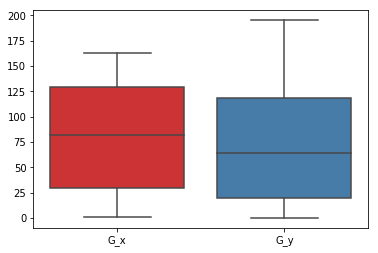

In [23]:
sns.boxplot(data=player[['G_x', 'G_y']], palette="Set1")

### New Features

In [24]:
#Batting Average
player['Bavg'] = (player.H / player.AB)

#Slugging
player['Slug'] = ((player.H - player['2B'] - player['3B'] - player.HR) + (player['2B']*2) + (player['3B']*3) + player.HR*4) / player.AB

#OBP
player['OBP'] = (player.H + player.BB + player.HBP) / (player.AB + player.BB + player.HBP + player.SF)

#Fielding Percentage - the sum of putouts and assists divided by the number of total chances (putouts + assists + errors)
player['FPct'] = (player.PO + player.A) / (player.PO + player.A + player.E)
player['FPct'].fillna(0, inplace = True)

print(player.info())
print(player.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 47 columns):
yearID                 19820 non-null object
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nu

### Pitching
Pitching Data will stand separate from the position "player" data frame.  Pitchers are evaluated and measured on different metrics and statistics when compared to position players.  Therefore, analysis of pitcher data should be distint from position players.  Similar to the batting table, more than one per record per play may exist in a year.  This could be due to being called up from and sent down to the minor leagues during the year, injuries or trades.  The instances where a player has multiple records in the pitching table per year are shown below.  There are 1643 instances where a player has more than one record per year in the Lahman database.  

In [25]:
#Identify Instances where a player has more than one batting record per year.
df = pitching.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]
print(df.shape)
print(pitching.shape)

(1643, 30)
(20822, 30)


Aggregate pitching data to the year and player grain.  

In [26]:
#Consolidate and Aggreagate
#print(pitching.groupby(['yearID', 'playerID']).sum().reset_index())
pitching = pitching.groupby(['yearID', 'playerID']).sum().reset_index()

#print(pitching)
print(pitching.shape)
#print(pitching.info())
print(pitching.describe())

(19118, 28)
             yearID         stint             W             L             G  \
count  19118.000000  19118.000000  19118.000000  19118.000000  19118.000000   
mean    2002.600429      1.182237      3.965791      3.965791     28.343760   
std        9.343516      0.619937      4.560622      3.974994     21.168742   
min     1985.000000      1.000000      0.000000      0.000000      1.000000   
25%     1995.000000      1.000000      0.000000      1.000000     10.000000   
50%     2003.000000      1.000000      2.000000      3.000000     26.000000   
75%     2011.000000      1.000000      6.000000      6.000000     40.000000   
max     2017.000000     10.000000     27.000000     21.000000     94.000000   

                 GS            CG           SHO            SV        IPouts  \
count  19118.000000  19118.000000  19118.000000  19118.000000  19118.000000   
mean       7.933780      0.458992      0.149597      1.998117    212.586201   
std       11.570255      1.440587      

Merge People table with Pitching.

In [27]:
pitching = pd.merge(pitching, people, on=['playerID'], how='left')
pitching.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19118 entries, 0 to 19117
Data columns (total 32 columns):
yearID      19118 non-null int64
playerID    19118 non-null object
stint       19118 non-null int64
W           19118 non-null int64
L           19118 non-null int64
G           19118 non-null int64
GS          19118 non-null int64
CG          19118 non-null int64
SHO         19118 non-null int64
SV          19118 non-null int64
IPouts      19118 non-null int64
H           19118 non-null int64
ER          19118 non-null int64
HR          19118 non-null int64
BB          19118 non-null int64
SO          19118 non-null int64
BAOpp       19118 non-null float64
ERA         19118 non-null float64
IBB         19118 non-null float64
WP          19118 non-null int64
HBP         19118 non-null float64
BK          19118 non-null int64
BFP         19118 non-null float64
GF          19118 non-null int64
R           19118 non-null int64
SH          19118 non-null float64
SF          19118 no

### Implement Minimum Games Pitched to Reduce Outliers
A minimum games played rule of 30 games per year is defined for the position player data frame.  A similar rule is to be implemented for pitchers.  From a biomechanical perspective, the pitching motion is incredibly stressfull on the arm and shoulder.  As such, pitchers typically play far fewer games per year than position players.  For example, a starting pitcher typically plays once every five games.  A middle reliever on an above average team could player every other game.  The boxplot and describe statement shown below show the entry point for the interquartile range is 10 games.  This will be implemented as the minimum games rule for pitchers.  

count    19118.000000
mean        28.343760
std         21.168742
min          1.000000
25%         10.000000
50%         26.000000
75%         40.000000
max         94.000000
Name: G, dtype: float64

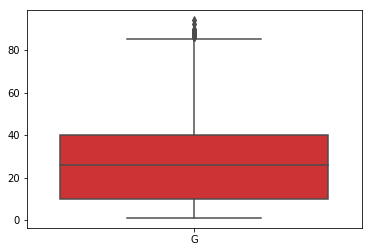

In [28]:
sns.boxplot(data=pitching[['G']], palette="Set1")
pitching.G.describe()

After the minimum games pitched rule is implemented, there are 14,473 records in the pitching dataframe.  

In [29]:
pitching = pitching[pitching.G > 9]
print(pitching.shape)
print(pitching.describe())

(14473, 32)
             yearID         stint             W             L             G  \
count  14473.000000  14473.000000  14473.000000  14473.000000  14473.000000   
mean    2002.483383      1.224003      5.096939      4.982796     35.969599   
std        9.325498      0.684049      4.688596      4.021284     18.721344   
min     1985.000000      1.000000      0.000000      0.000000     10.000000   
25%     1995.000000      1.000000      1.000000      2.000000     21.000000   
50%     2003.000000      1.000000      4.000000      4.000000     32.000000   
75%     2011.000000      1.000000      8.000000      8.000000     49.000000   
max     2017.000000     10.000000     27.000000     21.000000     94.000000   

                 GS            CG           SHO            SV        IPouts  \
count  14473.000000  14473.000000  14473.000000  14473.000000  14473.000000   
mean       9.979755      0.599185      0.194638      2.630830    269.543771   
std       12.561956      1.628711      

### Missing Values
No missing values exist in the pitching data frame.

In [30]:
df = pitching.isnull().sum()
df = df[df > 0]
print(df)
#df = pd.DataFrame({
#    'n Missing' : df,
#    '% Missing' : ((df / pitching.shape[0])*100).round(2)})
#
#cm = sns.light_palette("red", as_cmap=True)
#df.style.background_gradient(cmap=cm)

Series([], dtype: int64)


### Uniqueness
The printout below shown there is little concern for attributes with near zero variance.  Stint is expected to have little variance as it is rare for a player to have more than two stints per year.  Four stints in a season is the maximum observed in the remaining data.  People attributes such as bats and throws should have a low number of unique values.

In [31]:
df = pitching.nunique(dropna = False)
print(df)

yearID        33
playerID    3168
stint          4
W             26
L             21
G             83
GS            41
CG            21
SHO           10
SV            57
IPouts       792
H            273
ER           139
HR            47
BB           129
SO           282
BAOpp        884
ERA         1545
IBB           20
WP            27
HBP           22
BK            16
BFP         1070
GF            75
R            153
SH            23
SF            18
GIDP          41
weight        92
height        18
bats           3
throws         3
dtype: int64


#### MLB Players - Number of Years in League

The amount of time a player has been in the league can play an important role in a player’s salary. Rookie contracts are non-negotiable for the first few years (e.g., close to the league minimum), and then arbitrated after that until the player makes it to free agency (usually ~5 years). Once in free agency a player can go to the highest bidding team and salaries can increase significantly.  

To account for artificial limits early on and any potential relationship with free-agency contracts later in careers we calculated the season number ("seasonNum") variable by taking the difference between the current season year and a player's MLB debut year. This is a good proxy for time in the league for players. Even if a player is bumped back and forth between the minors and majors, once they get their MLB debut the clock starts ticking on their rookie contract and time to free agency.


In [32]:
# Load Career Dates from 'People' File
careerDates = pd.read_csv('./data/People.csv')[['playerID', 'debut']]
careerDates['debut'] = pd.to_datetime(careerDates['debut'], errors='coerce')
careerDates = careerDates.dropna() # some very old players have different date formats
careerDates['debutYear'] = careerDates['debut'].dt.year.astype(int)

# Join debutYear to player DF
player = player.set_index('playerID').join(careerDates[['playerID', 'debutYear']].set_index('playerID'))
player.reset_index(level=0, inplace=True)
player['seasonNum'] = (player['yearID'] - player['debutYear']) + 1

#### Write UnScaled Data to CSV
To give model developers flexibility to analyze and experiement with scaled and unscaled data, Unscaled CSV files will be created.

In [33]:
player.to_csv('./data/player.csv', sep=',', encoding='utf-8')
pitching.to_csv('./data/pitching.csv', sep=',', encoding='utf-8')

#Players with no Salary
#playerNoSalary = player[player.salary > 0]
#playerNoSalary.to_csv('./data/playerNoSal.csv', sep=',', encoding='utf-8')

### Scaling
As determined in prior assignments, the baseball data must be scaled.  Some attributes are ratios while others are cummulative integers.  

In [34]:
print(player.columns)

Index(['playerID', 'yearID', 'G_x', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB_x', 'CS_x', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'stint',
       'G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'SB_y', 'CS_y',
       'Primary', 'salary', 'weight', 'height', 'bats', 'throws',
       'Annual Average', 'AnnualPercentChange', 'Mult2017', 'MinSalaries',
       'adjSalary', 'adjMinSalaries', 'adjSalary2', 'Bavg', 'Slug', 'OBP',
       'FPct', 'debutYear', 'seasonNum'],
      dtype='object')


In [35]:
#Baseball Data must be scaled due to the combination of percentages and cummulative statistics.  
from sklearn.preprocessing import StandardScaler
#Save key attributes which cannot be scaled prior to scaling
df = player[['yearID', 'playerID', 'Primary', 'bats', 'throws']]
dfp = pitching[['yearID', 'playerID', 'bats', 'throws']]

#Drop Attributes which are not needed, can't be scaled or shouldn't be scaled
player = player.drop(['AnnualPercentChange', 'Mult2017', "Annual Average", 'yearID', 'playerID', 'Primary', 'bats', 'throws'], axis=1)
pitching = pitching.drop(['yearID', 'playerID', 'bats', 'throws'], axis=1)

colNames = player.columns
colNamesP = pitching.columns

#Scale data
scaler = StandardScaler()
playerScaled = scaler.fit_transform(player)
playerScaled = pd.DataFrame(playerScaled, columns=colNames)

pitchingScaled = scaler.fit_transform(pitching)
pitchingScaled = pd.DataFrame(pitchingScaled, columns=colNamesP)

#Merge Primary Position back into the dataframe
#player = pd.concat([df, player], axis=1, ignore_index=True)
playerScaled['yearID'] = df['yearID']
playerScaled['playerID'] = df['playerID']
playerScaled['Primary'] = df['Primary']
playerScaled['bats'] = df['bats']
playerScaled['throws'] = df['throws']

player['yearID'] = df['yearID']
player['playerID'] = df['playerID']
player['Primary'] = df['Primary']
player['bats'] = df['bats']
player['throws'] = df['throws']

pitchingScaled['yearID'] = dfp['yearID']
pitchingScaled['playerID'] = dfp['playerID']
pitchingScaled['bats'] = dfp['bats']
pitchingScaled['throws'] = dfp['throws']

pitching['yearID'] = dfp['yearID']
pitching['playerID'] = dfp['playerID']
pitching['bats'] = dfp['bats']
pitching['throws'] = dfp['throws']

print(player.info())
print(player.describe())
print(playerScaled.info())
print(playerScaled.describe())
print(pitching.info())
print(pitching.describe())
print(pitchingScaled.info())
print(pitchingScaled.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19820 entries, 0 to 19819
Data columns (total 46 columns):
G_x               19820 non-null int64
AB                19820 non-null int64
R                 19820 non-null int64
H                 19820 non-null int64
2B                19820 non-null int64
3B                19820 non-null int64
HR                19820 non-null int64
RBI               19820 non-null float64
SB_x              19820 non-null float64
CS_x              19820 non-null float64
BB                19820 non-null int64
SO                19820 non-null float64
IBB               19820 non-null float64
HBP               19820 non-null float64
SH                19820 non-null float64
SF                19820 non-null float64
GIDP              19820 non-null float64
stint             19820 non-null float64
G_y               19820 non-null float64
GS                19820 non-null float64
InnOuts           19820 non-null float64
PO                19820 non-null float64
A    

#### Write Scaled Data to CSV file

In [36]:
playerScaled.to_csv('./data/playerscale.csv', sep=',', encoding='utf-8')
pitchingScaled.to_csv('./data/pitchingscale.csv', sep=',', encoding='utf-8')

#Players with Salary
#playerNoSalaryScale = player[playerScaled.salary > 0]
#playerNoSalaryScale.to_csv('./data/playerNoSalscale.csv', sep=',', encoding='utf-8')

In [37]:
# Save pandas data frames as pickles
player.to_pickle("./analysisdata/player.pkl")
#playerNoSalary.to_pickle("./analysisdata/playerNoSal.pkl")
playerScaled.to_pickle("./analysisdata/playerScaled.pkl")
#playerNoSalaryScale.to_pickle("./analysisdata/playerNoSalScale.pkl")
pitching.to_pickle("./analysisdata/pitching.pkl")
pitchingScaled.to_pickle("./analysisdata/pitchingScaled.pkl")

------
### Data Description (Including New Features)
The overall strategy for the data preparation is to provide data files to the model developers which offer ultimate flexibility and do not restrict or discard data unless necessary.  There are two final data sets.

The first is the player data set.  It is the combination of batting, fielding, salary and inflation data per player per year.  Much effort was spent assuring only one summarized record per player per year exists in this file.  

The second is a subset of the player file for players with a salary.  As this is expected to be utilized to for the salary prediction task.  Both versions have also been scaled and saved as new data files if the model developers choose to use scaled versions of the data.  

Finally, all files are available to the modelers as CSV, pickle or in memory as pandas data frames if the modeler chooses to build from this notebook.  

#### Position Player File
The table below is a full description of the final position player file.


| Attribute      | Category      | Type     | DF_Type | Description                                                            |
|----------------|---------------|----------|---------|---------------------------------------------------------------------------------------|
| yearID         | Informational | Interval | int64   | The professional baseball season.                                                     |
| playerID       | Informational | nominal  | object  | Unique identifier for the player.                                                     |
| Primary        | Informational | nominal  | object  | The player's primary position during the year.                                        |
| G_x            | Informational | Interval | int64   | The number of games where the player batted during the specified year.                |
| R              | Batting       | Interval | int64   | Total runs scored by the player during the year.                                      |
| AB             | Batting       | Interval | int64   | Total at bats by the player during the year.                                          |
| H              | Batting       | Interval | int64   | Total hist by the player during the year.                                             |
| 2B             | Batting       | Interval | int64   | Total doubles by the player during the year.                                          |
| 3B             | Batting       | Interval | int64   | Total triples by the player during the year.                                          |
| HR             | Batting       | Interval | int64   | Total home runs for the player during the year.                                       |
| RBI            | Batting       | Interval | int64   | Total Runs Batted In by the player during the year.                                   |
| BB             | Batting       | Interval | float64 | Total bases on balls or walks by the player during the year.                          |
| SO             | Batting       | Interval | float64 | Total strikeouts by the player during the year.                                       |
| SB_x           | Batting       | Interval | float64 | Total stolen bases by the player during the year.                                     |
| CS_x           | Batting       | Interval | float64 | Total time the player was caught stealing during the year.                            |
| HBP            | Batting       | Interval | float64 | Total number of times the player was hit by a pitch during the year.                  |
| SF             | Batting       | Interval | float64 | Total number of sacrifice flies by the player during the year.                        |
| GIDP           | Batting       | Interval | float64 | The number of times the player grounded into a double play during the year.           |
| stint          | Fielding      | Interval | float64 | The number of stints the player had during the year.                                  |
| G_y            | Fielding      | Interval | float64 | The number of games the player played in the field.                                   |
| GS             | Fielding      | Interval | float64 | The number of games started in the field by the player.                               |
| InnOuts        | Fielding      | Interval | float64 | The number of outs the player played during the year.                                 |
| PO             | Fielding      | Interval | float64 | The number of put outs by the player during the year.                                 |
| A              | Fielding      | Interval | float64 | The number of assists by the player during the year.                                  |
| E              | Fielding      | Interval | float64 | Total errors by the player during the year.                                           |
| DP             | Fielding      | Interval | float64 | Total double plays by the player during the year.                                     |
| PB             | Fielding      | Interval | float64 | The number of passed balls by the player during the year.                             |
| SB_y           | Fielding      | Interval | float64 | The number of opponent stolen bases allowed by the player during the year.            |
| CS_y           | Fielding      | Interval | float64 | The number of time the player caught an opponent stealing during the year.            |
| salary         | Salary        | Interval | float64 | The total salary for the player per season.                                           |
| MinSalaries    | Salary        | Interval | float64 | The league minimum salary for the season.                                             |
| adjSalary      | Salary        | Interval | float64 | The player's salary adjusted for inflation in 2017 dollars.                           |
| adjMinSalaries | Salary        | Interval | float64 | The yearly league minimum salary adjusted for inflation in 2017 dollars.              |
| adjSalary2     | Salary        | Interval | float64 | The same as adjSalary except players without a salary listed will use adjMinSalaries. |
| height         | People        | Interval | float64 | The player's height.                                                                  |
| weight         | People        | Interval | float64 | The player's weight.                                                                  |
| bats           | People        | nominal  | object  | The player's dominant hand when batting.                                              |
| throws         | People        | nominal  | object  | The player's dominant hand when throwing.                                             |
| Bavg           | New Feature   | Ratio    | float64 | The player's batting average.                                                         |
| Slug           | New Feature   | Ratio    | float64 | The player's slugging percentage.                                                     |
| OBP            | New Feature   | Ratio    | float64 | The player's on base percentage.                                                      |
| FPct           | New Feature   | Ratio    | float64 | Aggregate fielding percentage by the player.                                          |
| debutYear      | New Feature   | Interval | int32   | The player's first year in the major leagues.                                         |
| seasonNum      | New Feature   | Interval | int64   | The number of seasons the player accumulated up to that point in time.                |

#### Pitcher File
The table shown below is a full description of the Pitcher file.

| Attribute 	| Category      	| Type     	| DF_Type 	| Description                                    	|
|-----------	|---------------	|----------	|---------	|------------------------------------------------	|
| yearID    	| Informational 	| Interval 	| int64   	| The professional baseball season.              	|
| playerID  	| Informational 	| nominal  	| object  	| Unique identifier for the player.              	|
| W         	| Pitching      	| Interval 	| int64   	| Games won by the pitcher.                      	|
| L         	| Pitching      	| Interval 	| int64   	| Games lost by the pitcher.                     	|
| G         	| Pitching      	| Interval 	| int64   	| Games played by the pitcher.                   	|
| GS        	| Pitching      	| Interval 	| int64   	| Games started by the pitcher.                  	|
| CG        	| Pitching      	| Interval 	| int64   	| Complete games by the pitcher.                 	|
| SHO       	| Pitching      	| Interval 	| int64   	| Shutouts by the pitcher.                       	|
| SV        	| Pitching      	| Interval 	| int64   	| Saves by the pitcher.                          	|
| Ipouts    	| Pitching      	| Interval 	| int64   	| Outs Pitched (innings pitched x 3)             	|
| H         	| Pitching      	| Interval 	| int64   	| Hits allowed by the pitcher                    	|
| ER        	| Pitching      	| Interval 	| int64   	| Earned allowed by the pitcher.                 	|
| HR        	| Pitching      	| Interval 	| int64   	| Home Runs allowed by the pitcher.              	|
| BB        	| Pitching      	| Interval 	| int64   	| Walks surrendered by the pitcher.              	|
| SO        	| Pitching      	| Interval 	| int64   	| Strikeouts by the pitcher.                     	|
| BAOpp     	| Pitching      	| Ratio    	| float64 	| Opponent's batting average.                    	|
| ERA       	| Pitching      	| Ratio    	| float64 	| Earned run average.                            	|
| IBB       	| Pitching      	| Ratio    	| float64 	| Intentional walks.                             	|
| WP        	| Pitching      	| Interval 	| int64   	| Wild pitches.                                  	|
| HBP       	| Pitching      	| Interval 	| float64 	| Batter hit by the pitcher.                     	|
| BK        	| Pitching      	| Interval 	| int64   	| Balks by the pitcher.                          	|
| BFP       	| Pitching      	| Interval 	| float64 	| Batters faced by the pitcher.                  	|
| GF        	| Pitching      	| Interval 	| int64   	| Games finished by the pitcher.                 	|
| R         	| Pitching      	| Interval 	| int64   	| Runs allowed by the pitcher.                   	|
| SH        	| Pitching      	| Interval 	| float64 	| Sacrifices by opposing batters.                	|
| SF        	| Pitching      	| Interval 	| float64 	| Sacrifice flies by opposing batters.           	|
| GIDP      	| Pitching      	| Interval 	| float64 	| Grounded into double plays by opposing batter. 	|
| weight    	| People        	| Interval 	| float64 	| The player's height.                           	|
| height    	| People        	| Interval 	| float64 	| The player's weight.                           	|
| bats      	| People        	| nominal  	| object  	| The player's dominant hand when batting.       	|
| throws    	| People        	| nominal  	| object  	| The player's dominant hand when throwing.      	|
